In [22]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorly as tl
import matplotlib.pyplot as plt

In [23]:
from config_dict import config_dict

In [24]:
from tensorly.decomposition._tucker import partial_tucker

In [25]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler

## need to change the company_data_dict.pkl to run for the different sector

In [26]:
dict_path = config_dict['final_pickle_file']

In [31]:
dict_path = './data/final_data/auto_company_data_dict.pkl'

In [28]:
dict_path = dict_path[1:]

In [29]:
dict_path

'/data/final_data/auto_company_data_dict.pkl'

In [32]:
with open(dict_path,'rb') as f:
    cmpy_dict = pickle.load(f)

In [33]:
mat = list(cmpy_dict.values())

In [14]:
x = mat[0]

In [20]:
def fill_rows(m,fix_shape = 19):
    if m.shape[0]>fix_shape:
        m = m[-fix_shape: , :]
    n_rows = m.shape[0]
    M = np.zeros(shape=(fix_shape , m.shape[1]))
    M[-n_rows:,:] = m
    for row_num in range(fix_shape-n_rows):
        M[row_num,:] = m[0,:]
    return M

In [21]:
mat = [fill_rows(i) for i in mat]

ValueError: could not convert string to float: 'Ashok Leyland'

Consolidation

In [26]:
## consildating the matrices off all companies
mat = np.dstack(mat)
mat = mat.transpose(2,0,1)


In [28]:
print('initial shape of matrix is :' , mat.shape)

initial shape of matrix is : (101, 19, 59)


# initial shape of matrix is : (96, 19, 59)

Normalization

In [29]:
# Normalization using (19,59) matrices
# Using Abs Max along the direction of (1,2)
x_max = np.abs(mat).max(0)
x_max[x_max==0] = 1 ## replace 0 with 1

x_norm = mat / x_max

In [35]:
print(x_norm.min()  , x_norm.max())

-1.0 1.0


### Steps:
1. Taking Median along timestep direction
2. Apply PCA and plot MAE vs no. of components



In [31]:
def mae_error(true_mat , recon_mat):
    val =  np.mean(np.abs(true_mat-recon_mat) )
    return val

In [32]:
def reconstructed_mat(mat , n_comps):
    assert n_comps <= min(mat.shape)
    u,s,vt = np.linalg.svd(mat)
    Sigma = np.zeros_like(mat)
    Sigma[:mat.shape[1] , :mat.shape[1]]  = np.diag(s)
    u = u[:,:n_comps]
    Sigma = Sigma[:n_comps,:]
    rec_mat = u.dot(Sigma.dot(vt))
    return rec_mat
    

In [33]:
def mae_n_comps(mat,n_comps):
    return mae_error(mat , reconstructed_mat(mat , n_comps))

In [34]:
def x_y_plot(mat):
    x_axis = range(1,min(mat.shape)+1)
    y_axis = [mae_n_comps(mat,i) for i in x_axis]
    return x_axis,y_axis

##### Visualization
x_axis , y_axis = x_y_plot(x_norm)

Text(0.5,1,'SVD - Median')

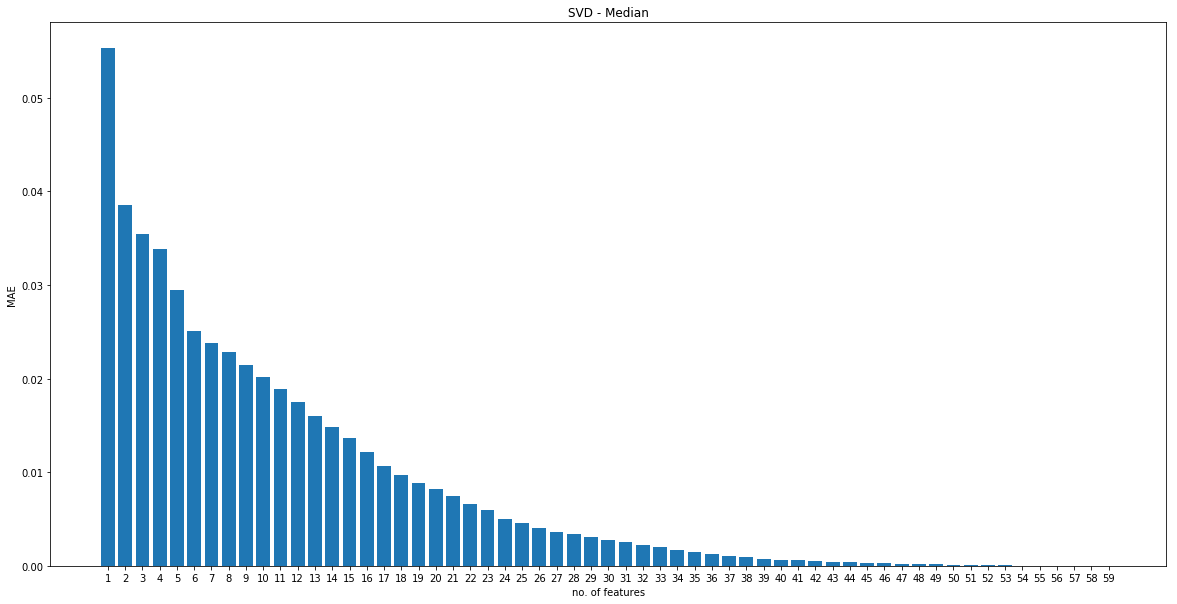

In [17]:
plt.figure(figsize=(20,10))
plt.bar(range(len(y_axis)) , y_axis)
plt.xticks(range(len(y_axis)) ,  x_axis)
plt.xlabel('no. of features')
plt.ylabel('MAE')
plt.title('SVD - Median')

Text(0.5,1,'elbow method')

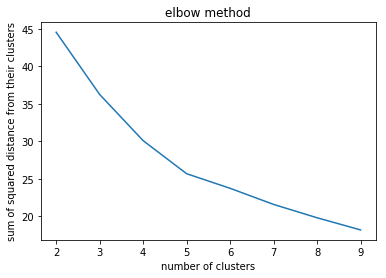

In [225]:
X = x_norm

from sklearn.cluster import KMeans

inertia_list = []
x_axis  = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = kmeans.inertia_
    inertia_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,inertia_list)
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distance from their clusters')
plt.title('elbow method')

In [30]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/median_5_clusters.csv',index = False)

NameError: name 'KMeans' is not defined

In [226]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/median_8_clusters.csv',index = False)

96


#---------------------------------------------
#---------------------------------------------

In [36]:
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor

### Tensor SVD

#### Using Tucker Decompostition

In [41]:
def tucker_recon_errors(a ):
    factors_range = range(1,a.shape[-1]+1)
    l_ = []
    
    for i in factors_range:
        core,factors = partial_tucker(a,rank=[i],modes=[2])
        rec = core.dot(factors[0].T)
        l_.append(mae_error(a,rec))
        
    return l_ , list(factors_range)

In [42]:
y_axis , x_axis = tucker_recon_errors(x_norm)

Text(0.5,1,'Tensor SVD')

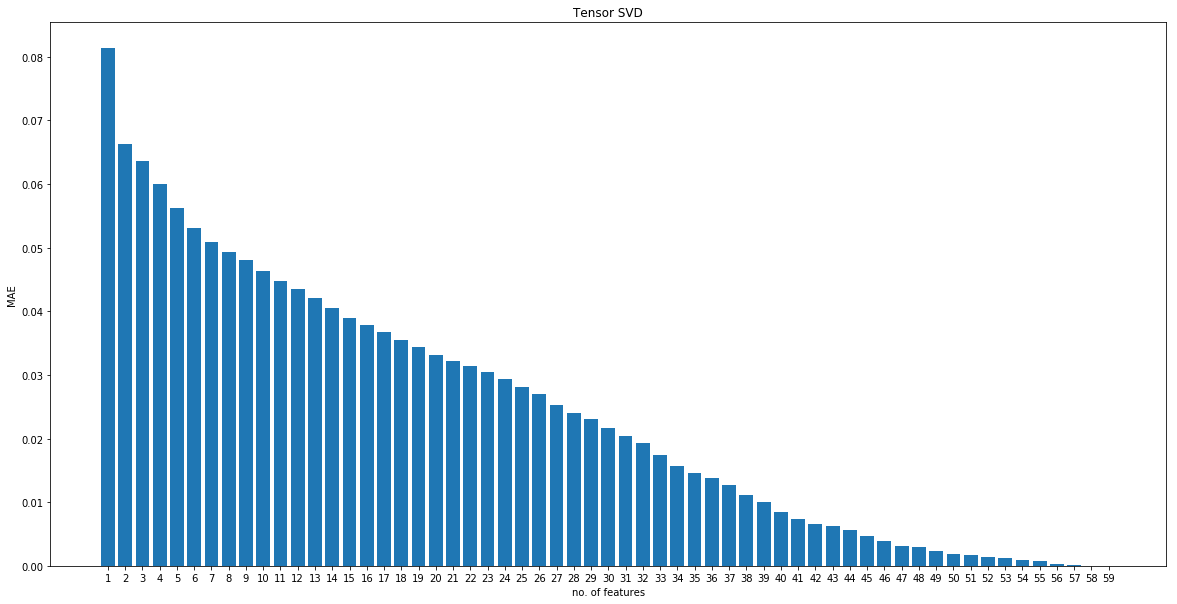

In [43]:
plt.figure(figsize=(20,10))
plt.bar(range(len(y_axis)) , y_axis)
plt.xticks(range(len(y_axis)) ,  x_axis)
plt.xlabel('no. of features')
plt.ylabel('MAE')
plt.title('Tensor SVD')

In [44]:
x_norm.shape

(101, 19, 59)

In [45]:
## pick 20 features from the 
core,factors = partial_tucker(x_norm,modes=[2],rank=[45])

In [47]:
core[0,0,0] , core[1,0,0]

(-0.7068223391345676, -0.5889324239154782)

In [48]:
core.shape

(101, 19, 45)

In [49]:
## unrolling the timesteps

In [50]:
def time_step_unroll(M):
    M = np.array([i.ravel() for i in M])
    return M

In [51]:
core_unroll = time_step_unroll(core)

In [52]:
core_unroll[0,0] , core_unroll[1,0]

(-0.7068223391345676, -0.5889324239154782)

In [53]:
core_unroll.max() , core_unroll.min()

(2.263691375907115, -3.517018350849465)

In [55]:
core_unroll.shape

(101, 855)

In [56]:
scaler = MinMaxScaler()
core_unroll = scaler.fit_transform(core_unroll)

In [57]:
core_unroll.max() , core_unroll.min()

(1.0000000000000002, 0.0)

Text(0.5,1,'Tensor-SVD elbow method')

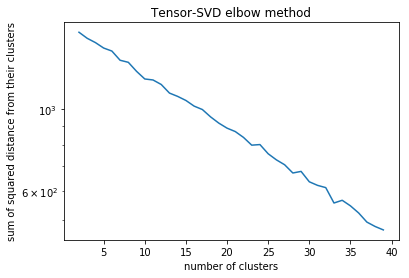

In [58]:
X = core_unroll

inertia_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = kmeans.inertia_
    inertia_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,inertia_list)
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distance from their clusters')
plt.yscale('log')
plt.title('Tensor-SVD elbow method')

In [63]:
from sklearn.metrics import silhouette_score

In [64]:
X = core_unroll

In [60]:
def get_f1(n_clus=10):
    l1 = []
    l2 = []
    for _ in range(10):
        kmeans = KMeans(n_clusters=n_clus)
        kmeans.fit(X)
        kmeans.labels_
        l1.append(kmeans.inertia_) ; l2.append(silhouette_score(X,kmeans.labels_))
    print(max(l1)-min(l1) , max(l2)-min(l2))
    return l1,l2

In [62]:
from sklearn.metrics import silhouette_score

65.63010577516889 0.1566050815474842
37.029212106602245 0.3577481961398506
22.10474111038525 0.31373932784568775
32.84551368621919 0.3332461478888712
47.33869700416949 0.28678840175893483
34.964768734694644 0.27795669389499167
43.61170567342788 0.26616644142150025
64.8516715800231 0.25213541452893595
34.9286917477159 0.18103493175764224
44.838205522907856 0.17788425457794738
41.434327337154855 0.20370120493488653
60.23081241236423 0.32826077870279285
55.13655204428028 0.16207550996363723
36.11316468351356 0.3048628028863464
50.234746623818864 0.14470482685339225
52.88511119842735 0.1537208266143362
53.362174045104325 0.2068034688023391
43.9712873587838 0.16888936799150917
23.30050312307901 0.20891674978268787
29.947961144650662 0.11316480670374499
36.959789740012866 0.12500754991455007
13.736745449426394 0.07463692345868429
23.255445570980896 0.17300014848297227
29.416309348403615 0.024510390508775227
17.63899721621499 0.07708296185330743
40.2782395958742 0.08565930039629013
15.0367514

Text(0.5,1,'Tensor-SVD elbow method')

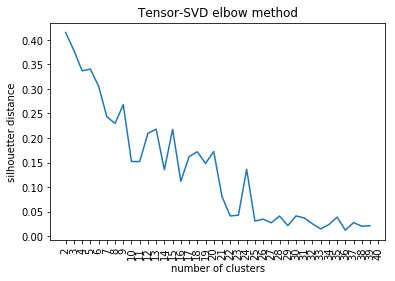

In [63]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis = []
for i in range(2,40):
    _,v1 = get_f1(i)
    sil_list.append(max(v1))
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

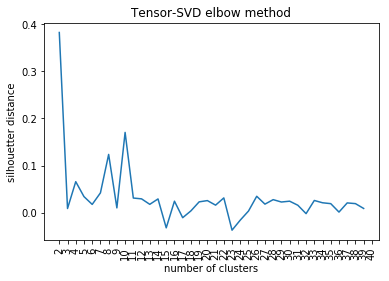

In [90]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = silhouette_score(X  , kmeans.labels_)
    sil_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

-1.0498221244986778

Text(0.5,1,'Tensor-SVD elbow method')

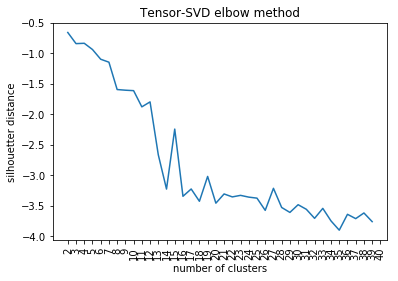

In [256]:
plt.plot(x_axis, [np.log(x) for x in sil_list])
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

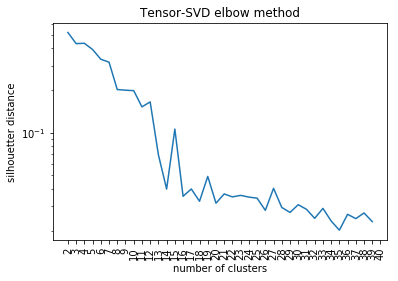

In [260]:
plt.plot(x_axis, sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

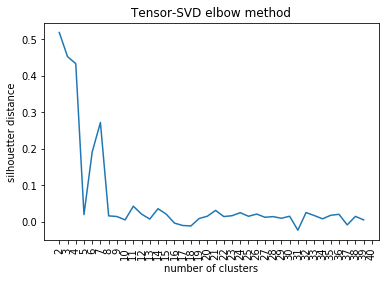

In [79]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = silhouette_score(X  , kmeans.labels_)
    sil_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

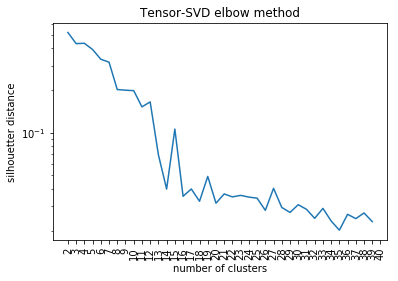

In [253]:
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

In [52]:
for i in range(1,len(inertia_list)):
    print(inertia_list[i]-inertia_list[i-1])

-85.70284536835766
-33.37625781756151
-26.9760593649155
-84.95758550234314
-25.643068983333023
-110.52797510721803
-27.81917729911015
-69.50204218329623
-1.7505382665982552
-36.54027823684328
-43.04286512589624
-17.897308131528803
-37.13699221297111
-58.64207827243854
-29.739284527081963
-12.013177269592802
-40.75130939550684
-26.49547903609789
-22.87948289822498
-37.40820344962026
-30.68265747481371
-7.622575111175138
-23.07511906160562
-1.6275791092481313
-25.469356087420806
-33.658431536173566
-8.629120952712242


In [46]:
X = core_unroll

In [47]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/TensorSVD_10_clusters.csv',index = False)

96


In [266]:
file_name

'./data/15_18/.xlsx'

In [270]:
clus_start = int(input('enter the starting cluster number'))
clus_end = int(input('enter the ending cluster number'))
file_name = str(clus_start)+'_'+str(clus_end)
file_name = os.path.join('./data',file_name+'.xlsx')
writer = pd.ExcelWriter(file_name)
for n_clus in range(clus_start , clus_end+1):
    kmeans = KMeans(n_clusters=n_clus)
    kmeans.fit(X)

    cmpy_names = list(cmpy_dict.keys())
    print(len(cmpy_names))

    ll = zip(list(cmpy_names) , list(kmeans.labels_))

    from collections import defaultdict

    ll_dict = defaultdict(list)

    for i,j in ll:
        ll_dict[j] = ll_dict[j]+[i]

    print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
    print_df.to_excel(writer,str(n_clus)+'clusters')
writer.save()

96
96
96
96
